# Mobile Phone Reviews Analysis - Text Mining

## Importing data 

In [4]:
import pandas as pd
import os
import datetime

In [5]:
data_dir = 'C:/Users/coskl/Desktop/Text Mining/Project/14-million-cell-phone-reviews/'
reviews_files = os.listdir(data_dir)

reviews_df = pd.DataFrame()

for file in reviews_files:
    current = pd.read_csv(data_dir + file, encoding = "ISO-8859-1")
    reviews_df = reviews_df.append(current)
    

In [6]:
print(len(reviews_df))
reviews_df.head()

1415133


,phone_url,date,lang,country,source,domain,score,score_max,extract,author,product
0,/cellphones/samsung-galaxy-s8/,5/2/2017,en,us,Verizon Wireless,verizonwireless.com,10.0,10.0,As a diehard Samsung fan who has had every Sam...,CarolAnn35,Samsung Galaxy S8
1,/cellphones/samsung-galaxy-s8/,4/28/2017,en,us,Phone Arena,phonearena.com,10.0,10.0,Love the phone. the phone is sleek and smooth ...,james0923,Samsung Galaxy S8
2,/cellphones/samsung-galaxy-s8/,5/4/2017,en,us,Amazon,amazon.com,6.0,10.0,Adequate feel. Nice heft. Processor's still sl...,R. Craig,"Samsung Galaxy S8 (64GB) G950U 5.8"" 4G LTE Unl..."
3,/cellphones/samsung-galaxy-s8/,5/2/2017,en,us,Samsung,samsung.com,9.2,10.0,Never disappointed. One of the reasons I've be...,Buster2020,Samsung Galaxy S8 64GB (AT&T)
4,/cellphones/samsung-galaxy-s8/,5/11/2017,en,us,Verizon Wireless,verizonwireless.com,4.0,10.0,I've now found that i'm in a group of people t...,S Ate Mine,Samsung Galaxy S8


## EDA 

In [7]:
# Taking only the reviews that are in english
reviews_en_df = reviews_df[reviews_df['lang'] == 'en']
print(len(reviews_en_df))
reviews_en_df.head()

554746


,phone_url,date,lang,country,source,domain,score,score_max,extract,author,product
0,/cellphones/samsung-galaxy-s8/,5/2/2017,en,us,Verizon Wireless,verizonwireless.com,10.0,10.0,As a diehard Samsung fan who has had every Sam...,CarolAnn35,Samsung Galaxy S8
1,/cellphones/samsung-galaxy-s8/,4/28/2017,en,us,Phone Arena,phonearena.com,10.0,10.0,Love the phone. the phone is sleek and smooth ...,james0923,Samsung Galaxy S8
2,/cellphones/samsung-galaxy-s8/,5/4/2017,en,us,Amazon,amazon.com,6.0,10.0,Adequate feel. Nice heft. Processor's still sl...,R. Craig,"Samsung Galaxy S8 (64GB) G950U 5.8"" 4G LTE Unl..."
3,/cellphones/samsung-galaxy-s8/,5/2/2017,en,us,Samsung,samsung.com,9.2,10.0,Never disappointed. One of the reasons I've be...,Buster2020,Samsung Galaxy S8 64GB (AT&T)
4,/cellphones/samsung-galaxy-s8/,5/11/2017,en,us,Verizon Wireless,verizonwireless.com,4.0,10.0,I've now found that i'm in a group of people t...,S Ate Mine,Samsung Galaxy S8


In [8]:
print(len(reviews_en_df['phone_url'].unique()))
print(reviews_en_df['phone_url'].unique())

4533
['/cellphones/samsung-galaxy-s8/'
 '/cellphones/samsung-galaxy-s6-edgeplus/'
 '/cellphones/samsung-galaxy-s8-plus/' ... '/cellphones/ericsson-pf-768/'
 '/cellphones/motorola-m3288/' '/cellphones/maxon-mx-3204/']


In [9]:
# Creating the function to return the phone model from the URL
def phone_model(url):
    phone_type = ' '.join(url[12:-1].split('-')).title()
    return phone_type

In [10]:
# Applying the phone_model function on the url 
reviews_en_df['phone_model'] = reviews_en_df['phone_url'].apply(phone_model)

C:\Users\coskl\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [11]:
print(len(reviews_en_df['phone_model'].unique()))

4533


In [12]:
# Creating another copy of the reviews_df
reviews_copy_df = reviews_en_df.copy()

In [13]:
# Found out that the dates are abit off - majority are in month/day/year but there is around 20k that is day/month/year
def check_date(row_date):
    month, day, year = row_date.split('/')
    isValid = True
    try:
        datetime.datetime(int(year), int(month), int(day))
    except:
        isValid = False
    
    return isValid

In [14]:
# Creating a year column
def review_year(row_date):
    month, day, year = row_date.split('/')

    return year

In [15]:
reviews_copy_df['date_check'] = reviews_copy_df['date'].apply(check_date)
reviews_copy_df['year'] = reviews_copy_df['date'].apply(review_year)
reviews_copy_df.head()

,phone_url,date,lang,country,source,domain,score,score_max,extract,author,product,phone_model,date_check,year
0,/cellphones/samsung-galaxy-s8/,5/2/2017,en,us,Verizon Wireless,verizonwireless.com,10.0,10.0,As a diehard Samsung fan who has had every Sam...,CarolAnn35,Samsung Galaxy S8,Samsung Galaxy S8,True,2017
1,/cellphones/samsung-galaxy-s8/,4/28/2017,en,us,Phone Arena,phonearena.com,10.0,10.0,Love the phone. the phone is sleek and smooth ...,james0923,Samsung Galaxy S8,Samsung Galaxy S8,True,2017
2,/cellphones/samsung-galaxy-s8/,5/4/2017,en,us,Amazon,amazon.com,6.0,10.0,Adequate feel. Nice heft. Processor's still sl...,R. Craig,"Samsung Galaxy S8 (64GB) G950U 5.8"" 4G LTE Unl...",Samsung Galaxy S8,True,2017
3,/cellphones/samsung-galaxy-s8/,5/2/2017,en,us,Samsung,samsung.com,9.2,10.0,Never disappointed. One of the reasons I've be...,Buster2020,Samsung Galaxy S8 64GB (AT&T),Samsung Galaxy S8,True,2017
4,/cellphones/samsung-galaxy-s8/,5/11/2017,en,us,Verizon Wireless,verizonwireless.com,4.0,10.0,I've now found that i'm in a group of people t...,S Ate Mine,Samsung Galaxy S8,Samsung Galaxy S8,True,2017


In [16]:
# Checking the number of wrong and correct dates 
wrong_dates = reviews_copy_df[reviews_copy_df['date_check'] == False]
print('No. of wrong dates:', len(wrong_dates))

correct_dates = reviews_copy_df[reviews_copy_df['date_check'] == True]
print('No. of correct dates:', len(correct_dates))

No. of wrong dates: 23448
No. of correct dates: 531298


In [17]:
# Created a function to clean the date for the incorrect date format
def clean_date(date):
    month, day, year = date.split('/')
    return '/'.join([day, month, year])

#     for index, row in reviews_df.iterrows():
#         month, day, year = row['date'].split('/')
#         if row['date_check'] == False:
#             reviews_df.loc[index, 'date'] = '/'.join([day, month, year])
#             row['date_check'] = True
#     return reviews_df

In [18]:
# Clean up the date format of the dataframe with wrong dates
wrong_dates['date'] = wrong_dates['date'].apply(clean_date)
wrong_dates

C:\Users\coskl\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,phone_url,date,lang,country,source,domain,score,score_max,extract,author,product,phone_model,date_check,year
1,/cellphones/samsung-s7262-duos-galaxy-ace/,11/17/2015,en,in,Zopper,zopper.com,10.0,10.0,Decent Functions and Easy to Operate Pros:- Th...,Expert Review,Samsung Galaxy Star Pro S7262 Black,Samsung S7262 Duos Galaxy Ace,False,2015
2,/cellphones/samsung-s7262-duos-galaxy-ace/,10/29/2015,en,in,Amazon,amazon.in,4.0,10.0,Not Good Phone such price. Hang too much and v...,Amazon Customer,Samsung Galaxy Star Pro GT-S7262 (Midnight Black),Samsung S7262 Duos Galaxy Ace,False,2015
3,/cellphones/samsung-s7262-duos-galaxy-ace/,10/29/2015,en,in,Amazon,amazon.in,6.0,10.0,not bad for features,Amazon Customer,Samsung Galaxy Star Pro GT-S7262 (Midnight Black),Samsung S7262 Duos Galaxy Ace,False,2015
4,/cellphones/samsung-s7262-duos-galaxy-ace/,10/29/2015,en,in,Amazon,amazon.in,10.0,10.0,Excellent product,NHK,Samsung Galaxy Star Pro GT-S7262 (Midnight Black),Samsung S7262 Duos Galaxy Ace,False,2015
5,/cellphones/samsung-s7262-duos-galaxy-ace/,10/27/2015,en,in,Amazon,amazon.in,8.0,10.0,Good in reasonable price,Rupali,Samsung Galaxy Star Pro GT-S7262 (Midnight Black),Samsung S7262 Duos Galaxy Ace,False,2015
6,/cellphones/samsung-s7262-duos-galaxy-ace/,10/27/2015,en,us,Amazon,amazon.com,2.0,10.0,I hate it no flash no front camera microphone ...,Ashney,Samsung Galaxy Star Pro DUOS S7262 Unlocked Ce...,Samsung S7262 Duos Galaxy Ace,False,2015
7,/cellphones/samsung-s7262-duos-galaxy-ace/,10/26/2015,en,in,Amazon,amazon.in,2.0,10.0,The phone is getting struck very frequently.. ...,Amazon Customer,Samsung Galaxy Star Pro GT-S7262 (Midnight Black),Samsung S7262 Duos Galaxy Ace,False,2015
8,/cellphones/samsung-s7262-duos-galaxy-ace/,10/25/2015,en,in,Amazon,amazon.in,6.0,10.0,Original product received with complete packag...,Amazon Customer,Samsung Galaxy Star Pro GT-S7262 (Midnight Black),Samsung S7262 Duos Galaxy Ace,False,2015
9,/cellphones/samsung-s7262-duos-galaxy-ace/,10/21/2015,en,in,Amazon,amazon.in,10.0,10.0,Good product from Samsung. Just right for ever...,Amazon Customer,Samsung Galaxy Star Pro GT-S7262 (Midnight Black),Samsung S7262 Duos Galaxy Ace,False,2015
10,/cellphones/samsung-s7262-duos-galaxy-ace/,10/20/2015,en,in,Amazon,amazon.in,10.0,10.0,Nice Budget phone,KARTHIKEYAN N,Samsung Galaxy Star Pro GT-S7262 (Midnight Black),Samsung S7262 Duos Galaxy Ace,False,2015


In [24]:
# Returning the cleaned dataframe use for analysis 
cleaned_df = correct_dates.append(wrong_dates, ignore_index=True)
cleaned_df = cleaned_df[cleaned_df['year'].astype(int) >= 2007]
cleaned_df.drop(columns=['phone_url', 'date_check', 'year'], inplace=True)

In [25]:
# Checking null rows
null_columns = cleaned_df.columns[cleaned_df.isna().any()]
cleaned_df[null_columns].isna().sum()

score        4494
score_max    4494
extract      4200
author       1188
dtype: int64

In [26]:
cleaned_df.dropna(subset=['extract'], inplace=True)
len(cleaned_df)

531699

In [ ]:
#Removing pre-2007 reviews
# date_list = cleaned_df.loc[:,'date'].tolist()
# year_list = []
# for dates in date_list:
#     year = dates[-4:]
#     if (int(year)>=2007):
#         year_list.append(year)
#     else:
#         year_list.append("drop")
# cleaned_df.insert(0, 'year', year_list)
# cleaned_df.drop( cleaned_df[ cleaned_df['year'] == "drop" ].index , inplace=True)
# cleaned_df.drop(['year'], axis=1, inplace = True)
# len(cleaned_df)

## Storing/Opening pickle file for the cleaned dataframe 

In [27]:
import pickle 

###@@@@@@@@@ THIS IS TO ***SAVE*** THE CLEANED DATAFRAME FROM ABOVE @@@@@@@@@###
# pickle.dump(cleaned_df, open("cleaned_reviews_df.pkl", "wb"))

###@@@@@@@@@ THIS IS TO ***OPEN*** THE CLEANED DATAFRAME FROM THE STORED PICKLE FILE @@@@@@@@@###
### CHECKPOINT - can just load the pickle file and start running your analysis
cleaned_df = pickle.load(open("cleaned_reviews_df.pkl", "rb"))

In [28]:
len(cleaned_df)

531699

# LDA Model

In [29]:
import nltk
import re
import gensim

def clean_extract(extract_data):
    stop_list = nltk.corpus.stopwords.words('english')
    tokenizer = nltk.tokenize.word_tokenize
    stemmer = nltk.stem.porter.PorterStemmer()

    extract_list  = [tokenizer(extract) for extract in extract_data]
    extract_list = [[w.lower() for w in extract] for extract in extract_list]
    extract_list = [[w for w in extract if re.search('^[a-z]+$',w)] for extract in extract_list]
    extract_list = [[w for w in extract if w not in stop_list] for extract in extract_list]
#     extract_list = [[stemmer.stem(w) for w in extract] for extract in extract_list]
    return extract_list

In [31]:
extract_list = cleaned_df['extract'].values.tolist()
extract_words = clean_extract(extract_list)

## Gensim LDA Model

In [32]:
import gensim

# Using gensim to create a dictionary object of all the words in all extracts
extract_dict = gensim.corpora.Dictionary(extract_words)

# Returning the word vector for each extract from the gensim dict of words
extract_vecs = [extract_dict.doc2bow(extract) for extract in extract_words]

In [34]:
# Finding the optimal number of topics
from gensim.models import CoherenceModel

model_list = []
coh_val = []
model_topics = []

for num_topic in range(3, 10):
    extract_lda_gensim = gensim.models.ldamodel.LdaModel(corpus=extract_vecs, id2word=extract_dict, num_topics=num_topic)
    coh_model = CoherenceModel(model=extract_lda_gensim, texts=extract_words, dictionary=extract_dict, coherence='c_v')
    model_topics.append(num_topic)
    model_list.append(extract_lda_gensim)
    coh_val.append(coh_model.get_coherence())
    print("Topic " + str(num_topic) + " Score: " + str(coh_model.get_coherence()))

Topic 3 Score: 0.4002669529670479
Topic 4 Score: 0.4327363705646269
Topic 5 Score: 0.41127359587131307
Topic 6 Score: 0.41417195899660714
Topic 7 Score: 0.43815965947182983
Topic 8 Score: 0.45251749430692023
Topic 9 Score: 0.4166528935165106


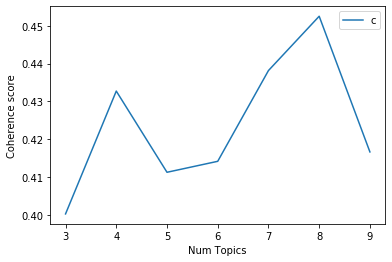

In [44]:
import matplotlib.pyplot as plt

x = range(3, 10)
plt.plot(x, coh_val)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [36]:
# Gensim LDA Model - topics
val = 0
model_num = 3
for model in model_list:
    print("Model #{} Coherence Score: {}".format(model_num, coh_val[val]))
    topics = model.show_topics(formatted=False)
    for topic, word_list in topics:
        topic_num = topic + 1
        result_list = []
        for word, word_prob in word_list:
            result_list.append(word)
        print("Topic {}: {}".format(topic_num, ', '.join(result_list)))
    model_num += 1
    val += 1
    print('----------------------------------------------------------------------------')

Model #3 Coherence Score: 0.4002669529670479
Topic 1: phone, one, got, bought, phones, new, would, get, first, iphone
Topic 2: phone, screen, great, use, camera, easy, love, like, features, nice
Topic 3: good, phone, battery, great, works, product, life, price, sim, card
----------------------------------------------------------------------------
Model #4 Coherence Score: 0.4327363705646269
Topic 1: phone, screen, use, easy, like, great, love, touch, small, really
Topic 2: good, phone, battery, camera, great, quality, life, price, excellent, nice
Topic 3: phone, phones, one, iphone, samsung, best, nokia, years, ever, love
Topic 4: phone, one, would, work, bought, got, get, new, use, great
----------------------------------------------------------------------------
Model #5 Coherence Score: 0.41127359587131307
Topic 1: phone, work, would, get, sim, time, working, got, problem, back
Topic 2: good, battery, phone, camera, quality, life, screen, great, mobile, best
Topic 3: good, phone, pr

In [37]:
import pickle 

###@@@@@@@@@ THIS IS TO ***SAVE*** THE GENSIM MODELS FROM ABOVE @@@@@@@@@###
pickle.dump(model_list, open("gensim_models.pkl", "wb"))

###@@@@@@@@@ THIS IS TO ***OPEN*** THE GENSIM MODELS FROM THE STORED PICKLE FILE @@@@@@@@@###
### CHECKPOINT - can just load the pickle file and start running your analysis
# gensim_models = pickle.load(open("gensim_models.pkl", "rb"))

## Mallet LDA Model

In [38]:
import gensim
import os 

os.environ.update({'MALLET_HOME':r'D:\\Softwares\\mallet-2.0.8'})
mallet_path = r'D:\\Softwares\\mallet-2.0.8\\bin\\mallet'

model_list_mallet = []
coh_val_mallet = []

for num_topic in range(3, 10):
    extract_lda_mallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=extract_vecs, id2word=extract_dict, num_topics=num_topic)
    coh_model_mallet = CoherenceModel(model=extract_lda_mallet, texts=extract_words, dictionary=extract_dict, coherence='c_v')
    model_list_mallet.append(extract_lda_mallet)
    coh_val_mallet.append(coh_model_mallet.get_coherence())
    print("Topic " + str(num_topic) + " Score: " + str(coh_model_mallet.get_coherence()))

Topic 3 Score: 0.40153661259582235
Topic 4 Score: 0.39716823484276176
Topic 5 Score: 0.43003942023445385
Topic 6 Score: 0.46741532979935946
Topic 7 Score: 0.4791484852124435
Topic 8 Score: 0.4865505900403278
Topic 9 Score: 0.494983106220992


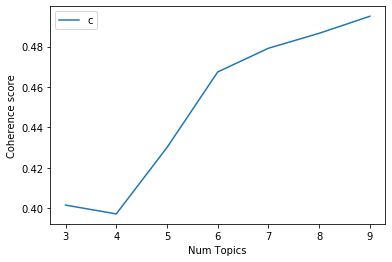

In [39]:
import matplotlib.pyplot as plt

x = range(3, 10)
plt.plot(x, coh_val_mallet)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [43]:
# Mallet LDA Model - topics
val = 0
mallet_model_num = 3
for model in model_list_mallet:
    print("Model #{} Coherence Score: {}".format(mallet_model_num, coh_val_mallet[val]))
    topics = model.show_topics(formatted=False)
    for topic, word_list in topics:
        topic_num = topic + 1
        result_list = []
        for word, word_prob in word_list:
            result_list.append(word)
        print("Topic {}: {}".format(topic_num, ', '.join(result_list)))
    mallet_model_num += 1
    val += 1
    print('----------------------------------------------------------------------------')

Model #3 Coherence Score: 0.40153661259582235
Topic 1: good, great, battery, camera, price, quality, product, nice, mobile, life
Topic 2: phone, love, screen, phones, samsung, iphone, easy, galaxy, great, android
Topic 3: phone, bought, works, time, buy, work, back, months, sim, working
----------------------------------------------------------------------------
Model #4 Coherence Score: 0.39716823484276176
Topic 1: battery, phone, time, work, product, back, life, problem, months, apps
Topic 2: good, camera, great, price, screen, quality, nice, features, mobile, excellent
Topic 3: phone, great, love, easy, screen, works, lot, smart, touch, ca
Topic 4: phone, bought, phones, samsung, iphone, android, galaxy, happy, nokia, years
----------------------------------------------------------------------------
Model #5 Coherence Score: 0.43003942023445385
Topic 1: price, product, samsung, mobile, iphone, buy, features, android, galaxy, money
Topic 2: phone, work, time, problem, working, months

In [41]:
import pickle 

###@@@@@@@@@ THIS IS TO ***SAVE*** THE MALLET MODELS FROM ABOVE @@@@@@@@@###
pickle.dump(model_list_mallet, open("mallet_models.pkl", "wb"))

###@@@@@@@@@ THIS IS TO ***OPEN*** THE GENSIM MODELS FROM THE STORED PICKLE FILE @@@@@@@@@###
### CHECKPOINT - can just load the pickle file and start running your analysis
# mallet_models = pickle.load(open("mallet_models.pkl", "rb"))

In [46]:
## Another Gensim run with more words taken out from the stop list 
import nltk
import re
import gensim

def clean_extract2(extract_data):
    stop_list = nltk.corpus.stopwords.words('english')
    stop_list += ['phone', 'iphone', 'nokia', 'samsung', 'htc', 'lg', 'galaxy', 'ca', '']
    tokenizer = nltk.tokenize.word_tokenize
    stemmer = nltk.stem.porter.PorterStemmer()

    extract_list  = [tokenizer(extract) for extract in extract_data]
    extract_list = [[w.lower() for w in extract] for extract in extract_list]
    extract_list = [[w for w in extract if re.search('^[a-z]+$',w)] for extract in extract_list]
    extract_list = [[w for w in extract if w not in stop_list] for extract in extract_list]
#     extract_list = [[stemmer.stem(w) for w in extract] for extract in extract_list]
    return extract_list

In [47]:
extract_list2 = cleaned_df['extract'].values.tolist()
extract_words2 = clean_extract2(extract_list2)

In [48]:
import gensim

# Using gensim to create a dictionary object of all the words in all extracts
extract_dict2 = gensim.corpora.Dictionary(extract_words2)

# Returning the word vector for each extract from the gensim dict of words
extract_vecs2 = [extract_dict2.doc2bow(extract) for extract in extract_words2]

In [49]:
# Finding the optimal number of topics
from gensim.models import CoherenceModel

model_list2 = []
coh_val2 = []
model_topics2 = []

for num_topic in range(3, 10):
    extract_lda_gensim2 = gensim.models.ldamodel.LdaModel(corpus=extract_vecs2, id2word=extract_dict2, num_topics=num_topic)
    coh_model2 = CoherenceModel(model=extract_lda_gensim2, texts=extract_words2, dictionary=extract_dict2, coherence='c_v')
    model_topics2.append(num_topic)
    model_list2.append(extract_lda_gensim2)
    coh_val2.append(coh_model2.get_coherence())
    print("Topic " + str(num_topic) + " Score: " + str(coh_model2.get_coherence()))

Topic 3 Score: 0.37720979072736577
Topic 4 Score: 0.4129551343848196
Topic 5 Score: 0.3671427833870802
Topic 6 Score: 0.42117797065136936
Topic 7 Score: 0.41291882112235495
Topic 8 Score: 0.4313795092804904
Topic 9 Score: 0.44016334248403677


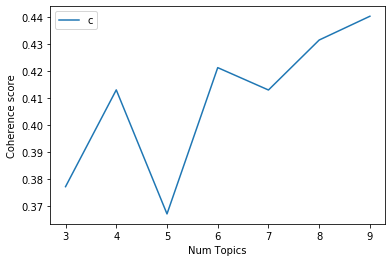

In [51]:
import matplotlib.pyplot as plt

x = range(3, 10)
plt.plot(x, coh_val2)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [53]:
# 2nd Gensim LDA Model - topics
val2 = 0
model_num2 = 3
for model in model_list2:
    print("Model #{} Coherence Score: {}".format(model_num2, coh_val2[val2]))
    topics = model.show_topics(formatted=False)
    for topic, word_list in topics:
        topic_num = topic + 1
        result_list2 = []
        for word, word_prob in word_list:
            result_list2.append(word)
        print("Topic {}: {}".format(topic_num, ', '.join(result_list2)))
    model_num2 += 1
    val2 += 1
    print('----------------------------------------------------------------------------')

Model #3 Coherence Score: 0.37720979072736577
Topic 1: battery, work, use, get, screen, one, would, time, got, like
Topic 2: one, phones, great, love, bought, new, like, got, first, would
Topic 3: good, great, camera, screen, quality, nice, easy, battery, excellent, use
----------------------------------------------------------------------------
Model #4 Coherence Score: 0.4129551343848196
Topic 1: work, would, sim, card, working, get, new, use, back, problem
Topic 2: battery, good, screen, camera, quality, life, great, nice, touch, like
Topic 3: great, good, love, use, easy, like, works, really, price, everything
Topic 4: one, phones, first, best, got, get, bought, years, ever, new
----------------------------------------------------------------------------
Model #5 Coherence Score: 0.3671427833870802
Topic 1: best, ever, mobile, smartphone, owned, phones, one, sony, market, android
Topic 2: battery, good, life, card, sim, charge, use, memory, apps, ok
Topic 3: great, good, works, pro

In [54]:
import pickle 

###@@@@@@@@@ THIS IS TO ***SAVE*** THE MALLET MODELS FROM ABOVE @@@@@@@@@###
pickle.dump(model_list2, open("gensim_models2.pkl", "wb"))

###@@@@@@@@@ THIS IS TO ***OPEN*** THE GENSIM MODELS FROM THE STORED PICKLE FILE @@@@@@@@@###
### CHECKPOINT - can just load the pickle file and start running your analysis
# mallet_models = pickle.load(open("mallet_models.pkl", "rb"))

In [55]:
# 2nd Mallet LDA Model
import gensim
import os 

os.environ.update({'MALLET_HOME':r'D:\\Softwares\\mallet-2.0.8'})
mallet_path = r'D:\\Softwares\\mallet-2.0.8\\bin\\mallet'

model_list_mallet2 = []
coh_val_mallet2 = []

for num_topic in range(3, 10):
    extract_lda_mallet2 = gensim.models.wrappers.LdaMallet(mallet_path, corpus=extract_vecs2, id2word=extract_dict2, num_topics=num_topic)
    coh_model_mallet2 = CoherenceModel(model=extract_lda_mallet2, texts=extract_words2, dictionary=extract_dict2, coherence='c_v')
    model_list_mallet2.append(extract_lda_mallet2)
    coh_val_mallet2.append(coh_model_mallet2.get_coherence())
    print("Topic " + str(num_topic) + " Score: " + str(coh_model_mallet2.get_coherence()))

Topic 3 Score: 0.33886764510583456
Topic 4 Score: 0.40415441462936047
Topic 5 Score: 0.4297441330925132
Topic 6 Score: 0.442586226238539
Topic 7 Score: 0.44981361903050854
Topic 8 Score: 0.4711436807881638
Topic 9 Score: 0.49534991688020447


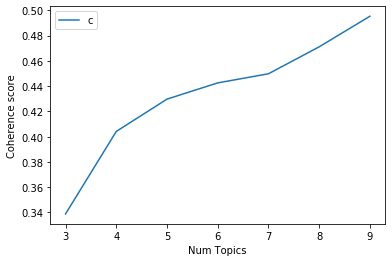

In [56]:
import matplotlib.pyplot as plt

x = range(3, 10)
plt.plot(x, coh_val_mallet2)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [57]:
# Mallet LDA Model - topics
val = 0
mallet_model_num = 3
for model in model_list_mallet2:
    print("Model #{} Coherence Score: {}".format(mallet_model_num, coh_val_mallet2[val]))
    topics = model.show_topics(formatted=False)
    for topic, word_list in topics:
        topic_num = topic + 1
        result_list = []
        for word, word_prob in word_list:
            result_list.append(word)
        print("Topic {}: {}".format(topic_num, ', '.join(result_list)))
    mallet_model_num += 1
    val += 1
    print('----------------------------------------------------------------------------')

Model #3 Coherence Score: 0.33886764510583456
Topic 1: great, love, battery, bought, phones, product, easy, buy, life, time
Topic 2: works, work, back, problem, sim, working, card, bad, problems, months
Topic 3: good, camera, screen, price, great, quality, nice, mobile, excellent, fast
----------------------------------------------------------------------------
Model #4 Coherence Score: 0.40415441462936047
Topic 1: good, battery, camera, quality, price, nice, mobile, life, fast, excellent
Topic 2: great, product, works, buy, work, apps, sim, happy, card, money
Topic 3: screen, love, great, phones, easy, features, android, touch, smartphone, size
Topic 4: time, back, bought, months, working, problem, days, problems, year, day
----------------------------------------------------------------------------
Model #5 Coherence Score: 0.4297441330925132
Topic 1: screen, phones, android, device, years, size, big, bit, note, perfect
Topic 2: good, camera, price, quality, nice, mobile, excellent, 

In [58]:
import pickle 

###@@@@@@@@@ THIS IS TO ***SAVE*** THE MALLET MODELS FROM ABOVE @@@@@@@@@###
pickle.dump(model_list_mallet2, open("mallet_models2.pkl", "wb"))

###@@@@@@@@@ THIS IS TO ***OPEN*** THE GENSIM MODELS FROM THE STORED PICKLE FILE @@@@@@@@@###
### CHECKPOINT - can just load the pickle file and start running your analysis
# mallet_models = pickle.load(open("mallet_models.pkl", "rb"))